**Mahan Madani - 99222092**

Assignment 3 (Part 2) - Persian text sentiment analysis

## Table of Contents:

- [Load Dataset and Import Libraries](##Load-Dataset-and-Import-Libraries)
- [Data Analysis and Preprocessing](##Data-Analysis-and-Preprocessing)
- [Feature Engineering](##Feature-Engineering)
- [Feature Encoding](##Feature-Encoding)
- [Utility Functions](##Utility-Functions)
- [Train and Evaluate Models](##Train-and-Evaluate-Model)
    - [Random Forest Classifier](###Random-Forest-Classifier)
    - [Balanced Random Forest Classifier](###Balanced-Random-Forest-Classifier)
    - [Support Vector Classifier](###Support-Vector-Classifier)
- [Pediction for Test Data](##Pediction-for-Test-Data)

## Load Dataset and Import Libraries

**Note**: I used Hazm in this project, which is a library to perform natural language processing tasks on Persian text. It offers various features for analyzing, processing, and understanding Persian text. You can use Hazm to normalize text, tokenize sentences and words, lemmatize words, assign part-of-speech tags, identify dependency relations, create word and sentence embeddings, or read popular Persian corpora.

In [512]:
import re

import pandas as pd
import numpy as np

from scipy.sparse import hstack
from sklearn.utils import resample

from hazm.utils import stopwords_list
from hazm import Stemmer

from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

After importing the dataset, I named the two existing columns Text and Sentiment. Our target is predicting the Sentiment of each text record.

In [513]:
df = pd.read_excel("dataset/train_data.xlsx", header=None)
df.columns = ['Text', 'Sentiment']
print(df.columns)
print(df.shape)

Index(['Text', 'Sentiment'], dtype='object')
(4924, 2)


## Data Analysis and Preprocessing

In [514]:
pd.options.display.max_columns = None
df.head(3)

,Text,Sentiment
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
2,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD


In [515]:
df.describe()

,Text,Sentiment
count,4924,4924
unique,4924,5
top,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,HAPPY
freq,1,1462


In [516]:
df['Sentiment'].value_counts()

Sentiment
HAPPY    1462
OTHER    1263
ANGRY    1012
SAD       845
FEAR      342
Name: count, dtype: int64

There is no need to check for duplicate values as shown in the previous section's results.
The dataset contains 4924 unique and non-null values in the text column.
A total of 5 different sentiments exist in the dataset.

Additionally, since we're working with persian text data, searching for outlier values is a tedious task and likely requires human input. Therefore I decided not to search for the outliers and simply try to clean the text as much as possible.

In [517]:
null_counts = df.isnull().sum()
null_table = pd.DataFrame(null_counts, columns=["Null Count"])
null_table

,Null Count
Text,0
Sentiment,0


This plot displays the distribution of our Target classes. As you can see, the dataset is imbalanced and we will need to address this issue when training models. I tried various methods which I'll explain further in this file.

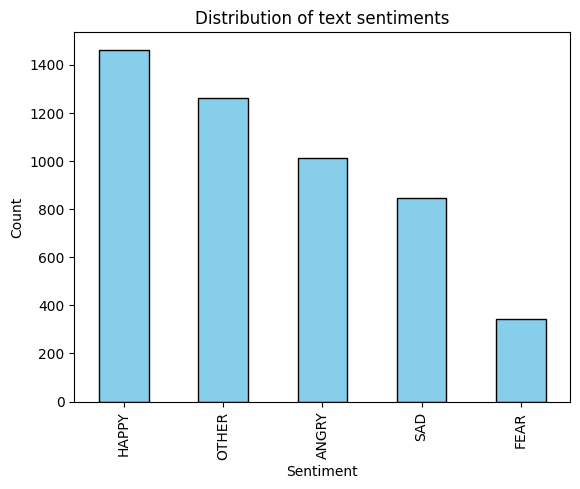

In [519]:
df['Sentiment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of text sentiments')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

## Feature Engineering

In [520]:
df.sample(5)

,Text,Sentiment
3644,اصلی نیست اصلا شارژ نمیشه از دیجی انتظار نداشتم,ANGRY
4725,کلا پیشنهاد نمیکنم حتی تو پیشنهاد ویژه,ANGRY
2970,مگه دوست پسرتونیم هعی قهر می‌کنید باید نازتونو...,ANGRY
1431,من انقدر تو دوست داشتنت وفادار بودم که الان حا...,SAD
2504,فقط جای فلش یکمی تنگه باعث میشه که فلش خط خطی شه,ANGRY


I defined a list of keywords usually associated with each class. I usued the training data as a reference but the data from the test set was not used to generate these lists. 

Each of these lists are used to extract new feature from the Text column. These features are: `Happy_Words` , `Sad_Words`, `Angry_Words`, and `Fear_Words`.

 For each record, if any of these words exists in the text column, then the value of the respective feature is set to 1.
 
 For example if the text contains words from `happy_list`, then the value of the `Happy_Words` feature is set to 1 for that specific record.

In [521]:
happy_list = "لذت خوب خوبه خوبی خوبیه عالی عالیه خوشحال خوشحالم خوشحالی شاد جذاب دوست عشق عاشق قشنگ زیبا راضی راضیم دوست مناسب شیک راحت محبوب مبارک مبارکه بهتر بهترین بهترینه".split()
sad_list = "گریه اشک تنها تنهایی غم غمگین غمگینم غمناک غم‌انگیز متاسفم متاسفانه سقوط کاش ای‌کاش کاشکی فراموش خبر ناراحت ناراحتی افسوس  خراب سخت".split()
angry_list = "قدیمی تعطیل تحمل ضرر سم سمی لعنت لعنتی لعنتیا فیک بلاک پاره آشغال احمق کثیف آتش آتیش اجباری اجباریه گران گرون گرونه بد بده بدتر بدتره بدترین".split()
fear_list = "ترس میترسم می‌ترسم نگران نگرانی نگرانم تباه تباهی بدبخت بدبختی فرار کابوس سقوط زلزله کرونا ویروس مرگ".split()

Certain letters in the persian alphabet have multiple characters associated with them. The function `replace_letters` replaces some of the less common versions of these letters with the standardized version.

In [522]:
def replace_letters(text):
    text = re.sub(r'ي', 'ی', text)
    text = re.sub(r'ك', 'ک', text)
    text = re.sub(r'آ', 'ا', text)
    return text

This function (`extract_features`) is used to add all of the sentiment-related features (as explained above) and a `Word_Count` feature, indicating the number of words each Text field has.

In [523]:
def extract_features(dataframe):
    dataframe['Text'] = dataframe['Text'].apply(replace_letters)

    dataframe['Happy_Words'] = dataframe['Text'].apply(lambda text: bool(set(text.split()) & set(happy_list))).astype(int)
    dataframe['Sad_Words']   = dataframe['Text'].apply(lambda text: bool(set(text.split()) & set(sad_list))).astype(int)
    dataframe['Angry_Words'] = dataframe['Text'].apply(lambda text: bool(set(text.split()) & set(angry_list))).astype(int)
    dataframe['Fear_Words']  = dataframe['Text'].apply(lambda text: bool(set(text.split()) & set(fear_list))).astype(int)

    dataframe['Word_Count']  = dataframe['Text'].apply(lambda text: len(text.split()))

The main goal of the `clean_text` function is to remove unnecessary characters from the text field and simplify the words as much as possible.

First, persian (and non-persian) symbols are removed from the text. I decied to keep emojis as they can help classify the overall tone of a sentence. 

Then I removed all consecutively repeated characters and replaced them with one instance of that character (hellllo will become helo).

I used a `Stemmer` from the Hazm library to simplify words and find their roots.

Finally, I used a modified version of the persian stop words list from Hazm. This list is used to remove stop words from the text. eliminating meaningless words and ensuring only the most crucial aspects of a sentence are stored.

In [591]:
persian_stop_words = stopwords_list() + ['نمی' , 'ها', 'های', 'ی']
persian_stop_words.remove('خوب')

def clean_text(text):
    text = text.lower()
    
    # Remove repeating characters and symbols
    text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r'[؟?!،؛٪×،«»‹›ـ…—–۰-۹#-_]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Stemming
    stemmer = Stemmer()
    words = text.split()
    words = [stemmer.stem(word) for word in words]

    # Remove stop words
    words = [word for word in words if (word not in persian_stop_words)]

    return ' '.join(words)


# Example
persian_text = "123  🏆 این متن فارسی باید پاکسازی شود و کلمات توقف حذف شوند."
cleaned_text = clean_text(persian_text)
print(cleaned_text)

🏆 متن فارس پاکساز توقف حذف


The new features are added to the dataset. The `Cleaned_Text` feature is the result of applying `clean_text()` to the existing text feature.

In [592]:
extract_features(df)
df['Cleaned_Text'] = df['Text'].apply(clean_text)
df.columns

Index(['Text', 'Sentiment', 'Happy_Words', 'Sad_Words', 'Angry_Words',
       'Fear_Words', 'Word_Count', 'Cleaned_Text'],
      dtype='object')

In [593]:
df.sample(5)

,Text,Sentiment,Happy_Words,Sad_Words,Angry_Words,Fear_Words,Word_Count,Cleaned_Text
484,خیلی کوچیکه برای بچه خوبه و واقعا جنس چرمش بده,HAPPY,1,0,1,0,10,خیل کوچیکه برا بچه خوبه واقعا جنس چرم بده
2371,فکت : هیچکس نمی تواند شما را دوست داشته باشد، ...,SAD,1,1,0,0,20,فک هیچکس نم تواند دوس ب کس برا گریه اس
1423,قرار بشه اقای رئیسی درخواستشو داده حالا دیگه ...,OTHER,0,0,0,0,9,قرار بشه اقا رئیس درخواستشو دیگه نمیدون
3601,قطعاً مظلوم و بی‌گناه بود. #مهسا_امینی,SAD,0,0,0,0,6,قطعاً مظلو بی‌گناه مهسا امین
761,برای اونها که عشق تویوتا هستن عالیه,HAPPY,1,0,0,0,7,برا اون عشق تویوتا هستن عالیه


## Feature Encoding

I used the TF-IDF vectorizer to embed the text data into vectors.

TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to quantify the importance of words in a document. It converts text into numerical vectors, where each dimension represents a word's importance relative to the document. It evaluates how frequently a word appears in a document (TF) and scales it by how rare the word is across all documents (IDF). 

I limited the number of new features to 5000, and set the ngram_range in a way that it would find bigrams and trigrams as well.

In [594]:
# Use TF-IDF Vectorizer to embed text

def encode_text(plain_text):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
    return tfidf_vectorizer.fit_transform(plain_text)

In [595]:
tfidf_matrix = encode_text(df['Cleaned_Text'])
tfidf_matrix.shape

(4924, 5000)

In my experiments with various models, PCA didn't have a positive impact and lowered the accuracy. Therefore I decided not to use pca and used the embeded data without dimension reduction.

In [605]:
# n_components = 200
# pca = PCA(n_components=n_components)
# tfidf_matrix_PCA = pca.fit_transform(tfidf_matrix.toarray())

## Utility Functions

I created three utility functions to simplify training and testing various models.

The `perform_cross_validation()` function uses stratified CV to improve results on the imbalanced dataset.

In [530]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    print(f"Mean accuracy of train set: {model.score(X_train, y_train):4f}")

In [532]:
sentiments = ['ANGRY', 'FEAR', 'HAPPY', 'OTHER', 'SAD']

def test_model(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy: >.6}\n")

    # Calculate Precision, Recall, and F1 score
    print(classification_report(y_test, y_pred))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=[8,3])
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False, linewidths=1,
                xticklabels=[f'Predicted {sentiment}' for sentiment in sentiments],
                yticklabels=[f'Actual {sentiment}' for sentiment in sentiments])

    plt.title('Confusion Matrix')

    plt.show()

In [533]:
def perform_cross_validation(model, X, y, repeats=2, folds=5):
    cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=13)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print("Cross-validation scores:", scores)
    print("Best result:", max(scores))
    

## Train and Evaluate Models

A MaxAbs scaler is used to scale all of the train data. The target variable remains untouched.

In [609]:
X = hstack((tfidf_matrix, df[['Word_Count', 'Happy_Words', 'Sad_Words', 'Angry_Words', 'Fear_Words']].values))
y = df['Sentiment']

In [610]:
scaler = MaxAbsScaler()
X = scaler.fit_transform(X)

In [611]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Random Forest Classifier

First I used a Random Forest Classifier with the class_weights set to balanced. This parameter can help with imbalanced datasets.

In [599]:
random_forest_model = RandomForestClassifier(class_weight='balanced', random_state=13)
train_model(random_forest_model, X_train, y_train)

Mean accuracy of train set: 0.998985


Accuracy: 0.588832

              precision    recall  f1-score   support

       ANGRY       0.64      0.38      0.48       188
        FEAR       0.64      0.49      0.55        72
       HAPPY       0.82      0.76      0.79       304
       OTHER       0.44      0.68      0.53       252
         SAD       0.49      0.41      0.45       169

    accuracy                           0.59       985
   macro avg       0.61      0.55      0.56       985
weighted avg       0.62      0.59      0.59       985



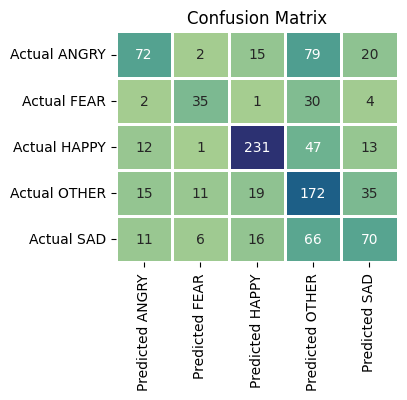

In [600]:
test_model(random_forest_model, X_test, y_test)

As you can see below, the balanced version of random forest has better CV results. (as expected)

In [601]:
perform_cross_validation(RandomForestClassifier(random_state=13), X, y, folds=5)

Cross-validation scores: [0.57360406 0.62030457 0.59086294 0.61928934 0.60162602 0.5857868
 0.61116751 0.60812183 0.59086294 0.58638211]
Best result: 0.6203045685279188


In [608]:
perform_cross_validation(RandomForestClassifier(class_weight='balanced', random_state=13), X, y, folds=5)

Cross-validation scores: [0.5715736  0.62944162 0.57360406 0.6213198  0.5995935  0.58680203
 0.62030457 0.60913706 0.60101523 0.58434959]
Best result: 0.6294416243654822


### Balanced Random Forest Classifier

The `BalancedRandomForestClassifier` is designed to work with imbalanced datasets (from `imblearn`)

In [612]:
balanced_random_forest = BalancedRandomForestClassifier(bootstrap=True, replacement=True, sampling_strategy='all')
train_model(balanced_random_forest, X_train, y_train)

Mean accuracy of train set: 0.791064


Accuracy: 0.568528

              precision    recall  f1-score   support

       ANGRY       0.59      0.39      0.47       188
        FEAR       0.46      0.64      0.54        72
       HAPPY       0.83      0.68      0.75       304
       OTHER       0.43      0.59      0.50       252
         SAD       0.49      0.50      0.50       169

    accuracy                           0.57       985
   macro avg       0.56      0.56      0.55       985
weighted avg       0.60      0.57      0.57       985



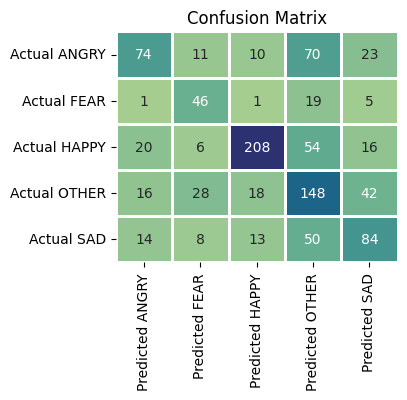

In [613]:
test_model(balanced_random_forest, X_test, y_test)

However the results are slightly worse than the Random Forest with weights set to balanced.

**Note that while accuracy is reduced, Recall is increased compared to the previous model.**

In [614]:
balanced_random_forest = BalancedRandomForestClassifier(bootstrap=True, replacement=True, sampling_strategy='all')
perform_cross_validation(balanced_random_forest, X_train, y_train)

Cross-validation scores: [0.59517766 0.56345178 0.58502538 0.56598985 0.57560356 0.58248731
 0.59390863 0.55837563 0.56472081 0.56670902]
Best result: 0.5951776649746193


### Support Vector Classifier

Finally I used a support vector classifier to be able to compare the tree-based models with a different model.

In [615]:
svc = SVC(kernel='rbf', C=1.0)
train_model(svc, X_train, y_train)

Mean accuracy of train set: 0.928154


Accuracy: 0.593909

              precision    recall  f1-score   support

       ANGRY       0.62      0.47      0.54       188
        FEAR       0.49      0.50      0.50        72
       HAPPY       0.83      0.74      0.78       304
       OTHER       0.44      0.69      0.54       252
         SAD       0.58      0.36      0.45       169

    accuracy                           0.59       985
   macro avg       0.59      0.55      0.56       985
weighted avg       0.62      0.59      0.60       985



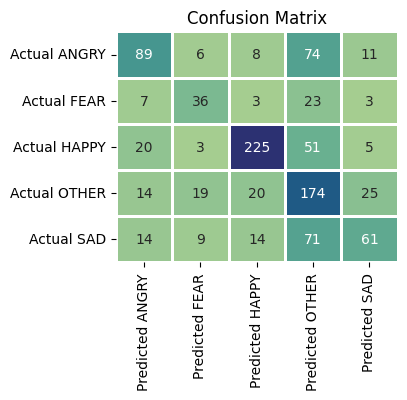

In [616]:
test_model(svc, X_test, y_test)

SVC performs slightly better than the tree-based models.

In [617]:
svc = SVC(kernel='rbf', C=1.0)
perform_cross_validation(svc, X, y, folds=5)

Cross-validation scores: [0.57664975 0.63857868 0.5857868  0.61015228 0.60365854 0.59695431
 0.60812183 0.60913706 0.60812183 0.57926829]
Best result: 0.6385786802030456


A bagging classifier was also used to if any performace difference can occur.

In [618]:
svc = SVC(kernel='rbf', C=1.0)
baggingClassifier = BaggingClassifier(estimator=svc, n_estimators=10, random_state=13)
perform_cross_validation(baggingClassifier, X, y)

Cross-validation scores: [0.5786802  0.63654822 0.58172589 0.59796954 0.58333333 0.59796954
 0.59796954 0.6071066  0.60304569 0.58231707]
Best result: 0.6365482233502539


## Prediction for Test Data

In this section, I used the random forest classifier to predict the sentiment of the test data.

In [619]:
test_df = pd.read_csv("dataset/3rdHW_test.csv", header=None)
test_df.columns = ['Text']

In [620]:
prediction_model = RandomForestClassifier(class_weight='balanced', random_state=13)
train_model(prediction_model, X, y)

Mean accuracy of train set: 0.999188


In [621]:
extract_features(test_df)
test_df['Cleaned_Text'] = test_df['Text'].apply(clean_text)
test_df.columns

Index(['Text', 'Happy_Words', 'Sad_Words', 'Angry_Words', 'Fear_Words',
       'Word_Count', 'Cleaned_Text'],
      dtype='object')

In [622]:
tfidf_matrix_prediction = encode_text(test_df['Cleaned_Text'])
X_prediction = hstack((tfidf_matrix_prediction, test_df[['Word_Count', 'Happy_Words', 'Sad_Words', 'Angry_Words', 'Fear_Words']].values))

X_prediction = scaler.transform(X_prediction)

In [623]:
test_df['Sentiment'] = prediction_model.predict(X_prediction)

In [624]:
prediction = pd.concat([test_df['Text'], test_df['Sentiment']], axis=1)
prediction.columns = ['X', 'Y']

In [625]:
prediction.to_csv('Prediction.csv', index=False)